In [98]:
# Directories
import os
os.chdir(r"E:\academy\OneDrive - IIT Delhi\3. IIT DELHI\2. Academics\1_PAPER\2_Analysis")
print(os.getcwd())

E:\academy\OneDrive - IIT Delhi\3. IIT DELHI\2. Academics\1_PAPER\2_Analysis


In [99]:
#Array packages
import cartopy.crs as ccrs
import pandas as pd
import numpy as np
import xarray as xr
import netCDF4 as nc4

from scipy.stats import kendalltau
import pymannkendall as mk

#plots
import matplotlib.pyplot as plt
import rioxarray as rio
import geopandas as gpd
from shapely.geometry import mapping
import matplotlib.ticker as ticker

#Progress meter
from dask.diagnostics import ProgressBar
from tqdm import tqdm

# Directories
import os
import glob
import dask
#import h5netcdf
import scipy


# 1. RE histogram norm vs Gamma


In [106]:
ss=0
mdl=4
ssn=['Pre-monsoon','Monsoon','Post-monsoon','Winter']
ssn_m=[[3,4,5],[6,7,8,9],[10,11],[12,1,2]]
model=["LIS_MERRA2","LIS_IMD","LIS_CHIRPS","LIS_ERA5","LIS_IMDc"]
var=['TotalPrecip_tavg','Evap_tavg','Qs_tavg','RE']
var_c=var+[f'{i}_C' for i in var]

basin_new=np.array(['Brahmaputra_trans', 'Ganga_trans', 'Indus_trans', 'Brahmaputra','East_Flowing_M_G', 'Cauvery', 'East_Flowing_Cauvery','East_Flowing_G_K', 'EFR_PK1', 'EFR MP1',
       'Ganga', 'Godavari', 'Indus', 'Krishna', 'Mahanadi', 'Mahi','Narmada', 'Pennar', 'Sabarmati', 'Subarnarekha', 'Tapi','WFR TK', 'WFR KS', 'EFR MP2','EFR_PK2'])
gdf = gpd.read_file('DATA_p/Shapefiles/India_trans/India_trans_new.shp')
gdf.iloc[:,2]=basin_new

lsm = xr.open_mfdataset(f"DATA_p/{model[mdl]}_1980_2021.nc",engine='netcdf4', parallel=True,chunks={'time': 'auto'})
lsm=lsm[['TotalPrecip_tavg','Evap_tavg','Qs_tavg']].compute()
lsm=lsm*60*60*24*30
lsm=lsm.where((lsm>=0.001)|(lsm.isnull()),0)
lsm=lsm.round(2)

dataset=[]
for i in range(len(basin_new)):
    
    B=gdf[gdf['Basin'] == basin_new[i]]
    lsm.rio.set_spatial_dims(y_dim="lat",x_dim="lon", inplace=True)
    lsm.rio.write_crs("EPSG:4326", inplace=True)
    lsm_clip = lsm.rio.clip(B.geometry.apply(mapping), B.crs, drop=True)
    A=lsm_clip.mean(dim=['lat','lon']).expand_dims(dim='region')
    dataset.append(A)
    
lsm_R = xr.concat(dataset, dim='region')
lsm_R['region'] = basin_new

RE=lsm_R["Qs_tavg"]/lsm_R["TotalPrecip_tavg"]
RE=RE.where(~np.isinf(RE))
RE=RE.where(~(lsm_R["Qs_tavg"]>lsm_R["TotalPrecip_tavg"]))
lsm_R['RE']=RE

In [116]:
lsm_R=lsm_R.interpolate_na(dim="time", method="linear")
mn=lsm_R.mean(dim='time', skipna=True)
lsm_R=lsm_R.fillna(lsm_R.mean(dim='time', skipna=True)) # to remove nans at the end

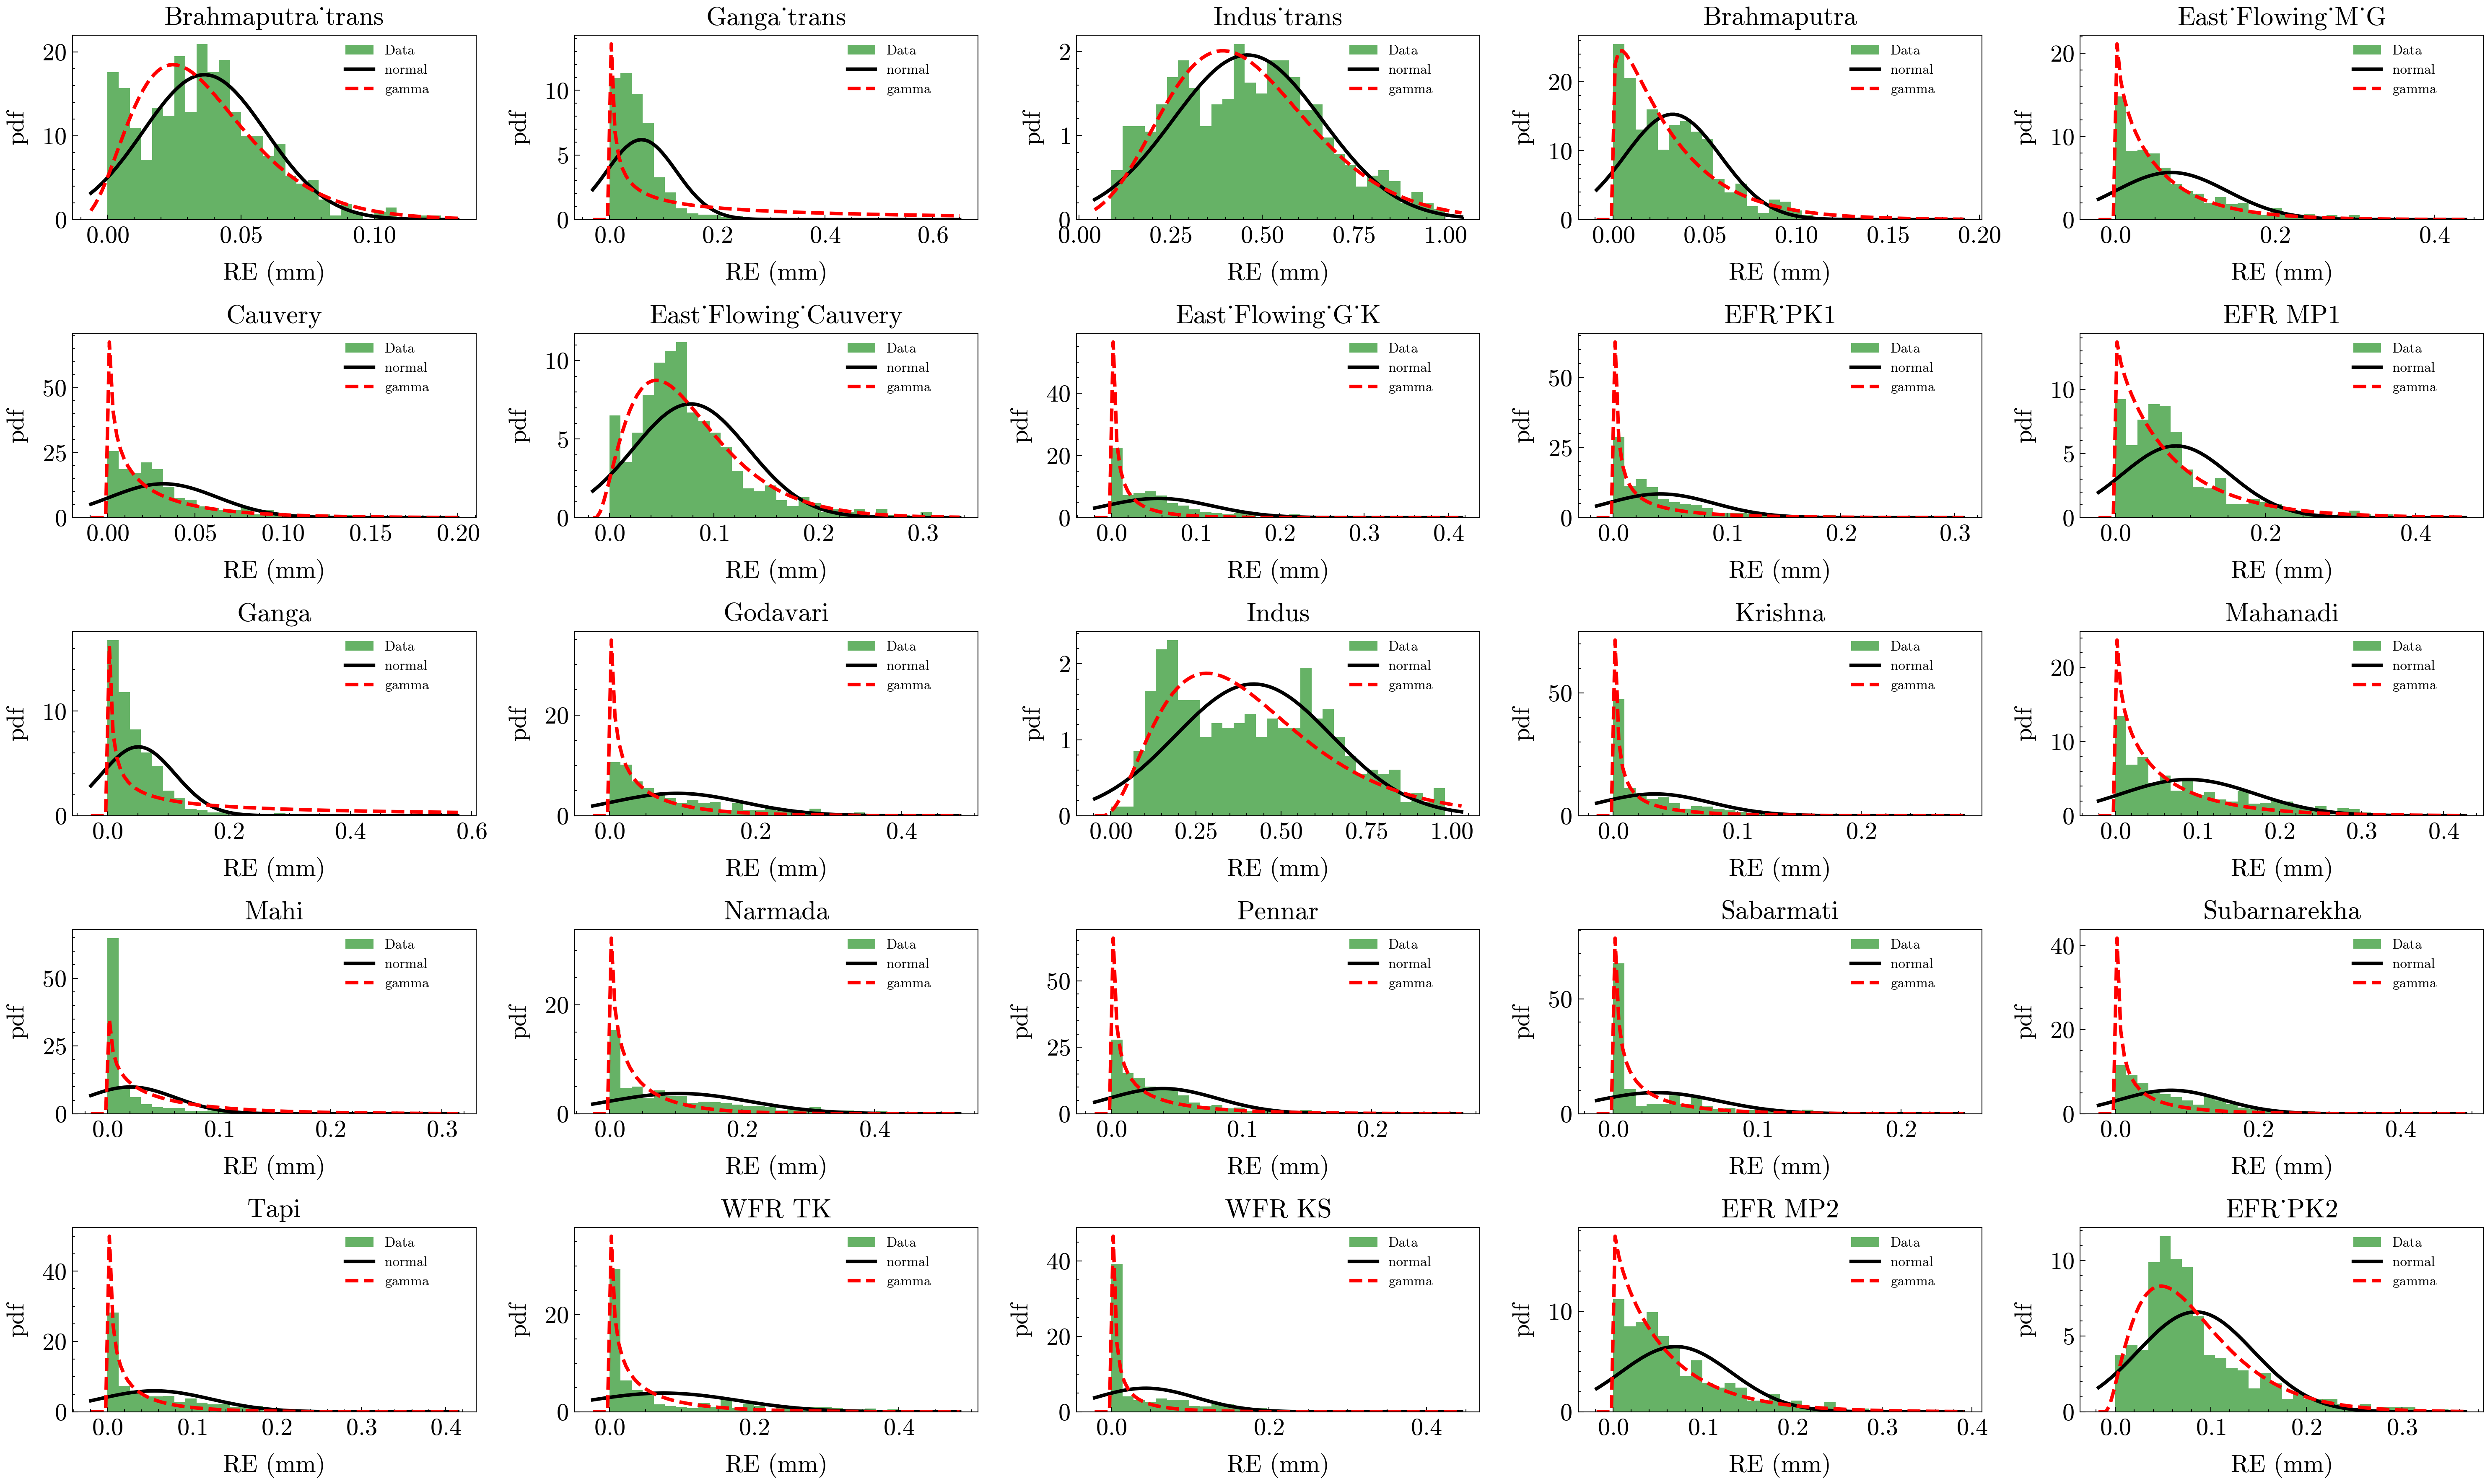

In [118]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, gamma
import scienceplots
plt.style.use(['science','no-latex','bright'])
fig, ax = plt.subplots(5,5,figsize=(20,12), facecolor='white', dpi=300)
ax=ax.flatten()
var=['TotalPrecip_tavg','Evap_tavg','Qs_tavg','RE']
vr=3

for i in range(0,len(basin_new)):

    reg=lsm_R.isel(region=i)[var[vr]]
    ax[i].hist(reg, bins=30, density=True, alpha=0.6, color='g', label='Data')
    # Fit a normal distribution to the data
    mu, std = norm.fit(reg)
    xmin, xmax = ax[i].get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    ax[i].plot(x, p, 'k', linewidth=2, label='normal')
    
    
    # Fit a gamma distribution to the data
    shape, loc, scale = gamma.fit(reg)
    pdf_gamma = gamma.pdf(x, shape, loc, scale)
    ax[i].plot(x, pdf_gamma, 'r--', linewidth=2, label='gamma')
    
    #ax[i].grid(True, color= 'grey', alpha=0.7, linestyle='dotted')
    ax[i].xaxis.set_tick_params(which='both', bottom=True, top=False,labelsize=14)
    ax[i].yaxis.set_tick_params(which='both', left=True, right=False,labelsize=14)
    ax[i].set_xlabel('RE (mm)',fontsize=14,labelpad=8, weight='bold')
    ax[i].set_ylabel('pdf',fontsize=14,labelpad=8, weight='bold')
    ax[i].set_title(f'{basin_new[i]}', fontsize=15)
    lgnd=ax[i].legend(loc='center', ncol=1,fontsize=8, bbox_to_anchor=(0.78, 0.81),frameon=False, borderpad=0.2, edgecolor='black')
    frame = lgnd.get_frame()
plt.tight_layout()
plt.savefig(f'1_Validation/output/1_RE analysis/gammavsnorm_{var[vr]}')
plt.show()

In [115]:
reg

<xarray.DataArray 'RE' (time: 504)>
array([       nan,        nan, 0.01319326, 0.00194964, 0.01984914,
       0.0880946 , 0.06849917, 0.11150449, 0.06561823, 0.19941138,
       0.10878865, 0.01492419, 0.01401392, 0.        , 0.02112725,
       0.00978366, 0.03142221, 0.03828396, 0.08467222, 0.09950518,
       0.0961519 , 0.06435819, 0.01035306, 0.        , 0.1817539 ,
       0.        , 0.        , 0.02749773, 0.01338978, 0.03796274,
       0.04428786, 0.07212841, 0.03254439, 0.07705739, 0.04629192,
       0.        , 0.        , 0.01278774, 0.        , 0.        ,
       0.02075997, 0.04805022, 0.04003267, 0.14100758, 0.15777382,
       0.21899263, 0.05469595, 0.04456998, 0.        , 0.010645  ,
       0.02393231, 0.02070825, 0.01215134, 0.03288716, 0.03228025,
       0.04190425, 0.08112843, 0.05119902, 0.05440147, 0.        ,
       0.06123808, 0.        , 0.        , 0.01772825, 0.00823149,
       0.02796633, 0.04324723, 0.05364423, 0.03624572, 0.15610972,
       0.03419733, 0.08977905, 0.08161616, 0.01580853, 0.        ,
       0.04917124, 0.01231394, 0.02481586, 0.0244054 , 0.19891943,
       0.04718643, 0.07862186, 0.0771319 , 0.        , 0.05669308,
       0.03832953, 0.01799845, 0.01484908, 0.03189279, 0.01775277,
       0.02380574, 0.02892278, 0.05767642, 0.08192654, 0.09617383,
       0.04927616, 0.02381681, 0.        , 0.        , 0.07844183,
...
       0.16829332, 0.08428125, 0.0281445 , 0.        , 0.        ,
       0.        , 0.        , 0.18081432, 0.00873606, 0.09048377,
       0.03706937, 0.04856437, 0.04179698, 0.00970107, 0.        ,
       0.        , 0.        , 0.        , 0.01050634, 0.06147049,
       0.1120843 , 0.08803572, 0.05878024, 0.09682872, 0.08509346,
       0.1061987 , 0.        , 0.        , 0.        , 0.00421538,
       0.        , 0.12564668, 0.09622017, 0.0737112 , 0.07877862,
       0.13815555, 0.06178213, 0.02942556, 0.00211061, 0.01288295,
       0.0226128 , 0.03338514, 0.        , 0.02470911, 0.04674376,
       0.06004798, 0.07690757, 0.06975203, 0.09701665, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.01917201,
       0.02099634, 0.06458437, 0.0789681 , 0.1541836 , 0.04524263,
       0.04766519, 0.03621524, 0.14282636, 0.03450678, 0.00464972,
       0.00874423, 0.        , 0.        , 0.02984119, 0.04232045,
       0.07966271, 0.08190798, 0.15156675, 0.        , 0.        ,
       0.03060806, 0.08599161, 0.        , 0.0651919 , 0.0069138 ,
       0.04466215, 0.12045308, 0.10884153, 0.22236341, 0.3178702 ,
       0.19961536, 0.        , 0.        , 0.        , 0.        ,
       0.03707688, 0.06461917, 0.02428004, 0.10326519, 0.06381579,
       0.21353644, 0.08791599, 0.10417458, 0.        ])
Coordinates:
  * time         (time) datetime64[ns] 1980-01-31 1980-02-29 ... 2021-12-31
    spatial_ref  int32 0
    region       <U20 'East_Flowing_G_K'

# 2. RE timseries standardized vs gamma standardized (SPI)

In [151]:
ss=0
mdl=4
ssn=['Pre-monsoon','Monsoon','Post-monsoon','Winter']
ssn_m=[[3,4,5],[6,7,8,9],[10,11],[12,1,2]]
model=["LIS_MERRA2","LIS_IMD","LIS_CHIRPS","LIS_ERA5","LIS_IMDc"]
var=['TotalPrecip_tavg','Evap_tavg','Qs_tavg','RE']
var_c=var+[f'{i}_C' for i in var]

gdf = gpd.read_file('DATA_p/Shapefiles/India_trans/India_trans_new.shp')
basin=np.array(gdf.iloc[:,2])

lsm = xr.open_mfdataset(f"DATA_p/{model[mdl]}_1980_2021.nc",engine='netcdf4', parallel=True,chunks={'time': 'auto'})
lsm=lsm[['TotalPrecip_tavg','Evap_tavg','Qs_tavg']]
lsm=lsm*60*60*24*30
lsm=lsm.where((lsm>=0.01)|(lsm.isnull()),0).compute()

#RE calculation
RE=lsm["Qs_tavg"]/lsm["TotalPrecip_tavg"]
RE=RE.where(~np.isinf(RE))
RE=RE.where(~(lsm["Qs_tavg"]>lsm["TotalPrecip_tavg"])) 

RE=RE.interpolate_na(dim="time", method="linear")
RE=RE.fillna(RE.mean(dim='time', skipna=True))

lsm['RE']=RE


lsm_monthly  =  lsm.groupby('time.month')
lsm_mean     =  lsm.groupby('time.month').mean(dim='time')
lsm_anom = lsm_monthly-lsm_mean  
lsm_std  = lsm.groupby('time.month').std(dim='time')
lsm_norm = (lsm_anom.groupby('time.month'))/lsm_std

<xarray.DataArray (time: 504)>
array([0.01088945, 0.01088945, 0.        , 0.00425857, 0.0014217 ,
       0.00911068, 0.00720068, 0.00794864, 0.01070118, 0.        ,
       0.00308151, 0.        , 0.        , 0.00071882, 0.00151465,
       0.00218473, 0.00133807, 0.0053882 , 0.00843539, 0.00605979,
       0.01587207, 0.03319555, 0.00251087, 0.        , 0.00075534,
       0.00143757, 0.00219291, 0.00292388, 0.00631807, 0.02283006,
       0.00820525, 0.00088506, 0.00791001, 0.04506474, 0.00805962,
       0.00599476, 0.0039299 , 0.00206486, 0.        , 0.00364231,
       0.00740604, 0.00510272, 0.02703341, 0.0137066 , 0.04560985,
       0.01983242, 0.01055166, 0.00649339, 0.        , 0.        ,
       0.00254905, 0.        , 0.00191777, 0.00570794, 0.01315884,
       0.00336501, 0.01219706, 0.00678632, 0.        , 0.00281072,
       0.        , 0.        , 0.        , 0.        , 0.004394  ,
       0.00335304, 0.00627473, 0.00417535, 0.00480618, 0.01157422,
       0.00205047, 0.        , 0.01035686, 0.        , 0.        ,
       0.        , 0.00183327, 0.00356543, 0.0032792 , 0.00643377,
       0.0148936 , 0.00970523, 0.00397913, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.00429409, 0.00153374,
       0.        , 0.0120975 , 0.00883969, 0.00988629, 0.01796328,
       0.00518974, 0.00367162, 0.00225144, 0.        , 0.00335237,
...
       0.0174602 , 0.        , 0.0018901 , 0.00378021, 0.0054874 ,
       0.0073775 , 0.        , 0.00712295, 0.02094505, 0.01130737,
       0.02503551, 0.01273247, 0.04305796, 0.00350154, 0.        ,
       0.        , 0.00347808, 0.00732881, 0.00608721, 0.00618197,
       0.0105341 , 0.0108235 , 0.00864742, 0.01526759, 0.0114778 ,
       0.00703842, 0.00216625, 0.        , 0.        , 0.        ,
       0.0012552 , 0.00255223, 0.01572301, 0.01214142, 0.02263391,
       0.02280351, 0.00733182, 0.        , 0.        , 0.00098044,
       0.00186601, 0.00284645, 0.        , 0.00189311, 0.00906317,
       0.00782632, 0.01470655, 0.0132983 , 0.02887976, 0.        ,
       0.00118556, 0.00237111, 0.00344193, 0.00462749, 0.        ,
       0.00608493, 0.0094698 , 0.00433299, 0.00681901, 0.01070405,
       0.00393279, 0.        , 0.        , 0.00372679, 0.00358181,
       0.0034213 , 0.00326597, 0.00184451, 0.00438188, 0.00603834,
       0.01459733, 0.02023014, 0.02003408, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.00331936, 0.00423626,
       0.00851166, 0.02132706, 0.01364703, 0.04488738, 0.08566371,
       0.02352363, 0.00533565, 0.00759766, 0.        , 0.01057394,
       0.02080678, 0.01475118, 0.0127341 , 0.01093322, 0.01176818,
       0.00903857, 0.02139557, 0.01855421, 0.        ])
Coordinates:
  * time         (time) datetime64[ns] 1980-01-31 1980-02-29 ... 2021-12-31
    spatial_ref  int64 0
    lat          float64 15.55
    lon          float64 78.05

In [155]:
#lsm = lsm.drop_vars('spatial_ref')
lsm

<xarray.Dataset>
Dimensions:           (time: 504, lat: 320, lon: 300)
Coordinates:
  * time              (time) datetime64[ns] 1980-01-31 1980-02-29 ... 2021-12-31
  * lat               (lat) float64 5.55 5.65 5.75 5.85 ... 37.25 37.35 37.45
  * lon               (lon) float64 68.05 68.15 68.25 ... 97.75 97.85 97.95
Data variables:
    TotalPrecip_tavg  (time, lat, lon) float32 nan nan nan ... 0.5022 0.5278
    Evap_tavg         (time, lat, lon) float64 nan nan nan ... 0.1288 0.1909
    Qs_tavg           (time, lat, lon) float64 nan nan nan nan ... 0.0 0.0 0.0

In [156]:
import climate_indices
from climate_indices import indices
da_precip_groupby = lsm.stack(point=('lat', 'lon')).groupby('point')
da_precip_groupby

DatasetGroupBy, grouped over 'point'
96000 groups with labels (5.550000190734863,, 68.0500....

In [157]:
# apply SPI to each `point`
scale = 1
distribution = climate_indices.indices.Distribution.gamma
data_start_year = 1980
calibration_year_initial = 2021
calibration_year_final = 2021
periodicity = periodicity = climate_indices.compute.Periodicity.monthly

da_spi = xr.apply_ufunc(indices.spi,
                        da_precip_groupby,
                        scale,
                        distribution,
                        data_start_year,
                        calibration_year_initial,
                        calibration_year_final,
                        periodicity)

C:\Users\sstar\anaconda3\envs\imed\Lib\site-packages\climate_indices\compute.py:712: RuntimeWarning: divide by zero encountered in divide
  alphas = (1 + np.sqrt(1 + 4 * a / 3)) / (4 * a)
C:\Users\sstar\anaconda3\envs\imed\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2168: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
C:\Users\sstar\anaconda3\envs\imed\Lib\site-packages\climate_indices\compute.py:707: RuntimeWarning: Mean of empty slice
  means = np.nanmean(calibration_values, axis=0)
C:\Users\sstar\anaconda3\envs\imed\Lib\site-packages\climate_indices\compute.py:710: RuntimeWarning: Mean of empty slice
  mean_logs = np.nanmean(logs, axis=0)


In [162]:
# unstack the array back into original dimensions
#da_spi = da_spi.unstack('point')
da_spi

<xarray.Dataset>
Dimensions:           (point: 96000, time: 504)
Coordinates:
  * time              (time) datetime64[ns] 1980-01-31 1980-02-29 ... 2021-12-31
  * point             (point) object MultiIndex
  * lat               (point) float64 5.55 5.55 5.55 5.55 ... 37.45 37.45 37.45
  * lon               (point) float64 68.05 68.15 68.25 ... 97.75 97.85 97.95
Data variables:
    TotalPrecip_tavg  (point, time) float64 nan nan nan nan ... nan nan nan nan
    Evap_tavg         (point, time) float64 nan nan nan nan ... nan nan nan nan
    Qs_tavg           (point, time) float64 nan nan nan nan ... nan nan nan nan

In [144]:
#da_spi = da_spi.unstack('point')
lsm.RE.isel(lat=100,lon=100)

<xarray.DataArray 'RE' (time: 504)>
array([0.00792379, 0.00792379,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
       0.01587207, 0.03319555,        nan,        nan,        nan,
              nan,        nan,        nan,        nan, 0.02283006,
              nan,        nan,        nan, 0.04506474,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan, 0.02703341, 0.0137066 , 0.04560985,
       0.01983242,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan, 0.01315884,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan, 0.01157422,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
       0.0148936 ,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan, 0.0120975 ,        nan, 0.00988629, 0.01796328,
              nan,        nan,        nan,        nan,        nan,
...
       0.0174602 ,        nan,        nan,        nan,        nan,
              nan,        nan,        nan, 0.02094505, 0.01130737,
       0.02503551, 0.01273247, 0.04305796,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan, 0.01526759,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan, 0.01572301, 0.01214142, 0.02263391,
       0.02280351,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan, 0.01470655, 0.0132983 , 0.02887976,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
       0.01459733, 0.02023014, 0.02003408,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan, 0.02132706, 0.01364703, 0.04488738, 0.08566371,
       0.02352363,        nan,        nan,        nan, 0.01057394,
       0.02080678, 0.01475118, 0.0127341 , 0.01093322,        nan,
              nan, 0.02139557, 0.01855421, 0.00792379])
Coordinates:
  * time         (time) datetime64[ns] 1980-01-31 1980-02-29 ... 2021-12-31
    spatial_ref  int64 0
    lat          float64 15.55
    lon          float64 78.05

<xarray.Dataset>
Dimensions:           (time: 504, region: 25)
Coordinates:
  * time              (time) datetime64[ns] 1980-01-31 1980-02-29 ... 2021-12-31
    spatial_ref       int32 0
  * region            (region) <U20 'Brahmaputra_trans' ... 'EFR_PK2'
Data variables:
    TotalPrecip_tavg  (region, time) float32 17.93 39.72 78.98 ... 522.8 60.16
    Evap_tavg         (region, time) float64 21.09 27.65 35.63 ... 89.52 119.5
    Qs_tavg           (region, time) float64 1.782 3.4 4.823 ... 151.6 10.63
    RE                (region, time) float64 0.09938 0.08561 ... 0.29 0.1766